<a href="https://colab.research.google.com/github/HamedFarahani89/Quantum-Computing-Lab/blob/main/TFQ_tutorial_mnist_detials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantum Neural Network for Image Classification

This notebook implements a **Quantum Neural Network (QNN)** for image classification using **TensorFlow Quantum (TFQ)**. The model is trained on a binarized and downscaled version of the **MNIST dataset**. The approach follows the TensorFlow Quantum tutorial, adapting the model for a **4×4 quantum circuit representation** of the input images.

## Overview of the Process:
1. **Data Preprocessing**:
   - Load the MNIST dataset and normalize pixel values.
   - Downscale images from **28×28 to 4×4** using `tf.image.resize()`.
   - Convert grayscale pixel values into binary (0 or 1) using a threshold.
   - Remove contradicting labels (images that appear with different labels in the dataset).

2. **Quantum Circuit Encoding**:
   - Each 4×4 image is mapped to a **16-qubit quantum circuit** using `cirq.GridQubit.rect(4, 4)`.
   - Pixels with value `1` are encoded using **X gates** on corresponding qubits.

3. **Quantum Neural Network Model**:
   - A **parametrized quantum circuit (PQC)** is designed with `cirq.XX` and `cirq.ZZ` layers.
   - A classical **Keras model** is built using `tfq.layers.PQC()`, where the circuit acts as a trainable quantum layer.

4. **Training and Evaluation**:
   - The model is trained using the **Hinge loss function** with an **Adam optimizer**.
   - The model is evaluated on test data after training.

This notebook serves as an introduction to quantum machine learning (QML) and demonstrates how quantum circuits can be used within deep learning models.

> **Note:** This implementation is adapted from the TensorFlow Quantum tutorial, with modifications to the preprocessing and model-building steps.




In [1]:
! pip install tensorflow==2.15.0

In [2]:
! pip install tensorflow-quantum==0.7.3

# Required Libraries for Quantum Machine Learning

This notebook utilizes a combination of classical and quantum computing libraries to implement a **Quantum Neural Network (QNN)**. Below are the essential libraries used:

## **1. TensorFlow & TensorFlow Quantum**
- `tensorflow`: A deep learning framework for building neural networks.
- `tensorflow_quantum`: An extension of TensorFlow designed for quantum machine learning, enabling hybrid quantum-classical models.

## **2. Quantum Computing with Cirq**
- `cirq`: A Python framework for designing and simulating quantum circuits.
- `cirq.contrib.svg.SVGCircuit`: A tool for visualizing quantum circuits in SVG format.

## **3. Mathematical & Data Processing Libraries**
- `sympy`: A symbolic mathematics library used for defining trainable parameters in quantum circuits.
- `numpy`: A fundamental library for numerical computations.
- `collections`: Provides data structures like `defaultdict` for efficient data handling.

## **4. Visualization Tools**
- `matplotlib.pyplot`: A plotting library for visualizing data and quantum circuits.
- `seaborn`: An enhancement of Matplotlib for statistical data visualization.

### **Jupyter Notebook Configuration**
- `%matplotlib inline`: Ensures that plots render directly within the notebook.

These libraries are essential for implementing and visualizing a hybrid quantum-classical deep learning model. 🚀


In [5]:
# Import TensorFlow for deep learning capabilities
import tensorflow as tf

# Import TensorFlow Quantum (TFQ) for quantum machine learning
import tensorflow_quantum as tfq

# Import Cirq for quantum circuit simulation
import cirq

# Import SymPy for symbolic mathematics (used for parameterized quantum circuits)
import sympy

# Import NumPy for numerical operations
import numpy as np

# Import Seaborn for data visualization
import seaborn as sns

# Import collections for handling structured data (e.g., dictionaries and default dictionaries)
import collections

# Enable inline plotting for Matplotlib in Jupyter Notebook
%matplotlib inline

# Import Matplotlib for visualization
import matplotlib.pyplot as plt

# Import SVG circuit visualization tool from Cirq
from cirq.contrib.svg import SVGCircuit


## **Loading, Preprocessing, and Encoding Data**  

This section focuses on loading the **MNIST dataset**, preparing it for quantum computation, and encoding it into quantum circuits. The dataset consists of **28×28 grayscale images of handwritten digits (0-9)**, which need to be transformed for quantum processing.

### **Preprocessing Steps:**
1. **Normalization:** The pixel values (ranging from `[0, 255]`) are scaled to `[0.0, 1.0]` to enhance training efficiency.  
2. **Resizing:** The images are downsampled from **28×28 to 4×4** to fit within the qubit constraints of quantum circuits.  
3. **Binarization:** Each pixel is converted to `0` or `1` using a threshold of `0.5`, ensuring compatibility with quantum states.  
4. **Binary Classification Selection:** Only two specific digits (e.g., **3 and 6**) are kept for a **binary classification task**.  
5. **Removing Conflicting Labels:** Images that are assigned to both classes due to preprocessing inconsistencies are removed to maintain clean labels.  
6. **Quantum Encoding:** The binarized images are mapped to **quantum circuits**, where each pixel corresponds to a qubit. If a pixel is `1`, an `X` gate is applied to initialize the qubit in the excited state; otherwise, it remains in the ground state.


In [6]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Each image is a 28×28 pixel matrix of numbers ranging from 0 to 255.
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

In [7]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 170,
        253, 253, 253, 253, 253, 225, 172, 253, 242, 195,  64,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  49, 238, 253, 253, 253, 253,
        253, 253, 253, 253, 251,  93,  82,  82,  56,  39,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  18, 219, 253, 253, 253, 253,
        253, 198, 182, 247, 241,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  80, 156, 107, 253, 253,
        205,  11,   0,  43, 154,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
         90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 139, 253,
        190,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 190,
        253,  70,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  35,
        241, 225, 160, 108,   1,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         81, 240, 253, 253, 119,  25,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  45, 186, 253, 253, 150,  27,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,  16,  93, 252, 253, 187,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 249, 253, 249,  64,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  46, 130, 183, 253, 253, 207,   2,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  39,
        148, 229, 253, 253, 253, 250, 182,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  24, 114, 221,
        253, 253, 253, 253, 201,  78,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  23,  66, 213, 253, 253,
        253, 253, 198,  81,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,  18, 171, 219, 253, 253, 253, 253,
        195,  80,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,  55, 172, 226, 253, 253, 253, 253, 244, 133,
         11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0, 136, 253, 25

5


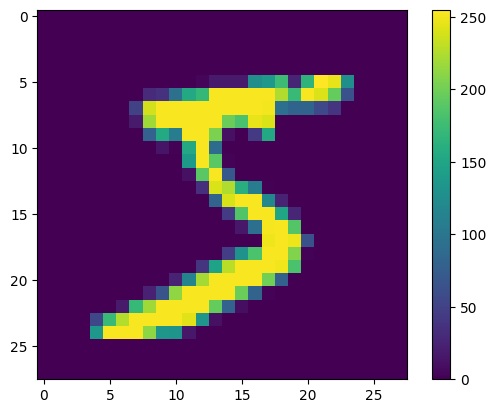

In [8]:
print(y_train[0])

plt.imshow(x_train[0])
plt.colorbar()

In [9]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [10]:
# `y_train` and `y_test` contain the class labels (numbers from 0 to 9).
y_train[0]

5

In [11]:
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[...,
                                                           np.newaxis] / 255.0

x_train[0].shape

(28, 28, 1)

In [12]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x, y

In [13]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


True


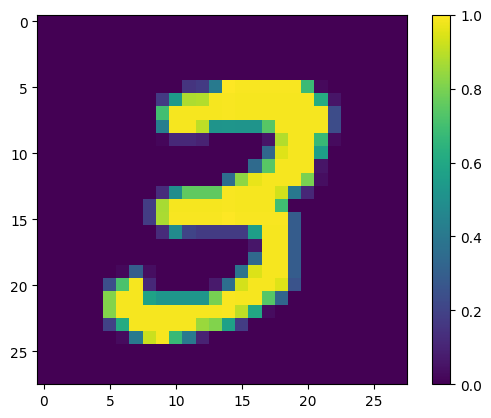

In [14]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

In [15]:
x_train_small = tf.image.resize(x_train, (4, 4)).numpy()
x_test_small = tf.image.resize(x_test, (4, 4)).numpy()

True


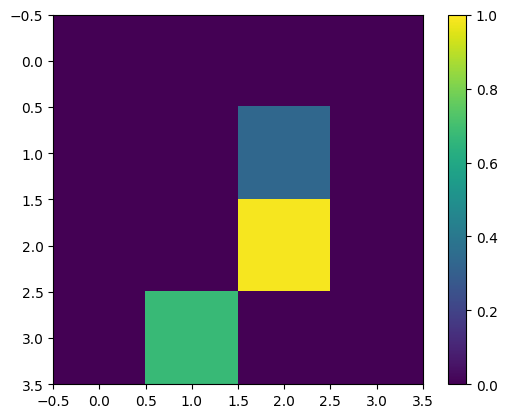

In [16]:
print(y_train[0])

plt.imshow(x_train_small[0, :, :, 0], vmin=0, vmax=1)
plt.colorbar()

In [20]:
x_train_small[0, :, :, 0]

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333334, 0.        ],
       [0.        , 0.        , 0.9882353 , 0.        ],
       [0.        , 0.6745098 , 0.        , 0.        ]], dtype=float32)

In [17]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x, y in zip(xs, ys):
        orig_x[tuple(x.flatten())] = x
        mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
        x = orig_x[flatten_x]
        labels = mapping[flatten_x]
        if len(labels) == 1:
            new_x.append(x)
            new_y.append(next(iter(labels)))
        else:
            # Throw out images that match more than one label.
            pass

    num_uniq_3 = sum(
        1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(
        1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ",
          num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [18]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Number of unique images: 10387
Number of unique 3s:  4912
Number of unique 6s:  5426
Number of unique contradicting labels (both 3 and 6):  49

Initial number of images:  12049
Remaining non-contradicting unique images:  10338


In [19]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [21]:
x_train_bin[0]

array([[[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [1.],
        [0.]],

       [[0.],
        [1.],
        [0.],
        [0.]]], dtype=float32)

In [22]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Number of unique images: 193
Number of unique 3s:  80
Number of unique 6s:  69
Number of unique contradicting labels (both 3 and 6):  44

Initial number of images:  10338
Remaining non-contradicting unique images:  149


### Quantum Neural Network (QNN) Model

In this notebook, we construct a **Quantum Neural Network (QNN)** using **TensorFlow Quantum (TFQ)**. The QNN consists of the following key components:

#### 1. **Quantum Circuit**
The QNN is built upon a quantum circuit, created using the **Cirq** library. This circuit is a **parameterized quantum circuit (PQC)** that is trained to perform binary classification. The circuit is composed of quantum gates applied to **quantum bits (qubits)**, and the output is measured through a readout qubit.

#### 2. **Model Architecture**
The model architecture is based on Keras' **Sequential API**, consisting of the following layers:

- **Input Layer**: The model takes the quantum circuit as input, which is encoded as a **TensorFlow string**.
- **PQC Layer**: The **PQC layer** processes the quantum circuit and measures the expected value of the readout qubit. This layer returns the output, which is used for classification.

The output of the PQC layer is then used for binary classification.

#### 3. **Loss Function**
The **Hinge Loss** function is used to evaluate the performance of the model. Hinge loss is commonly used in **binary classification tasks**, especially in support vector machines (SVMs). It penalizes predictions that are far from the correct class and encourages the model to output a value closer to the true class label. The hinge loss function computes the margin between the predicted and actual values and minimizes it during training.

#### 4. **Accuracy Metric**
The model uses a custom metric called **hinge accuracy** to evaluate how well the model is performing. This metric compares the true labels and predicted labels (after applying a threshold) to determine if the model's classification is correct. The **hinge accuracy** metric is designed to work with the output range `[-1, 1]`, where values greater than `0` indicate the positive class, and values less than `0` indicate the negative class.

#### 5. **Training**
The model is compiled using the **Adam optimizer**, which is a popular choice for training neural networks. The model is then trained on the prepared quantum data for several epochs, adjusting the quantum gates' parameters to minimize the hinge loss and improve the model's performance.


https://quantumai.google/reference/python/cirq/GridQubit

In [30]:
def convert_to_circuit(image):
    """Encode truncated classical image into quantum datapoint."""

    # Flatten the image into a 1D array of pixel values (0 or 1)
    values = np.ndarray.flatten(image)
    # print(values)

    # Create a 4x4 grid of qubits for encoding the image
    qubits = cirq.GridQubit.rect(4, 4)
    # print(qubits)

    # Initialize a quantum circuit to store the operations
    circuit = cirq.Circuit()

    # Iterate through each pixel value in the flattened image
    for i, value in enumerate(values):
        # If the pixel value is 1, apply a quantum X gate to the corresponding qubit
        if value:
            circuit.append(cirq.X(qubits[i]))  # X gate flips the qubit to |1>

    # Return the constructed quantum circuit
    return circuit

# Call the function on the first image from the dataset (x_train_bin)
convert_to_circuit(x_train_bin[0])


(2, 2): ───X───

(3, 1): ───X───

In [31]:
x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

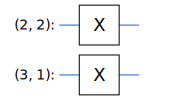

In [32]:
SVGCircuit(x_train_circ[0])

In [33]:
bin_img = x_train_bin[0, :, :, 0]
indices = np.array(np.where(bin_img)).T
indices

array([[2, 2],
       [3, 1]])

In [36]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)


In [38]:
class CircuitLayerBuilder():

    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

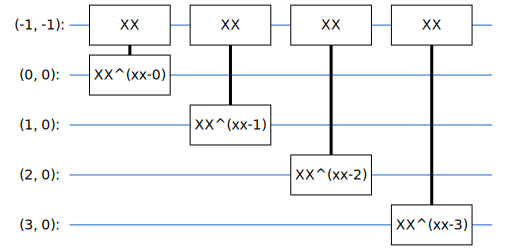

In [39]:
demo_builder = CircuitLayerBuilder(data_qubits=cirq.GridQubit.rect(4, 1),
                                   readout=cirq.GridQubit(-1, -1))

circuit = cirq.Circuit()
demo_builder.add_layer(circuit, gate=cirq.XX, prefix='xx')
SVGCircuit(circuit)

In [40]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)  # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(data_qubits=data_qubits, readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [41]:
model_circuit, model_readout = create_quantum_model()

In [42]:
# Build the Keras model.
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0 * y_train_nocon - 1.0
y_test_hinge = 2.0 * y_test - 1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(loss=tf.keras.losses.Hinge(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[hinge_accuracy])

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32 (128.00 Byte)
Trainable params: 32 (128.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
EPOCHS = 3
BATCH_SIZE = 32

NUM_EXAMPLES = len(x_train_tfcirc)

In [ ]:
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(x_train_tfcirc_sub,
                        y_train_hinge_sub,
                        batch_size=32,
                        epochs=EPOCHS,
                        verbose=1,
                        validation_data=(x_test_tfcirc, y_test_hinge))

qnn_results = model.evaluate(x_test_tfcirc, y_test)

Epoch 1/3
324/324 [==============================] - 909s 3s/step - loss: 0.8894 - hinge_accuracy: 0.6116 - val_loss: 0.5361 - val_hinge_accuracy: 0.7702
Epoch 2/3
324/324 [==============================] - 903s 3s/step - loss: 0.4213 - hinge_accuracy: 0.8046 - val_loss: 0.3784 - val_hinge_accuracy: 0.8226
Epoch 3/3
62/62 [==============================] - 30s 482ms/step - loss: 0.3452 - hinge_accuracy: 0.9037


In [ ]:
qnn_history.history

{'loss': [0.8894150257110596, 0.4212566912174225, 0.36560243368148804],
 'hinge_accuracy': [0.6115933656692505,
  0.8045910596847534,
  0.8702739477157593],
 'val_loss': [0.5360777974128723, 0.3783501982688904, 0.3451511859893799],
 'val_hinge_accuracy': [0.7701612710952759,
  0.8225806355476379,
  0.9037298560142517]}

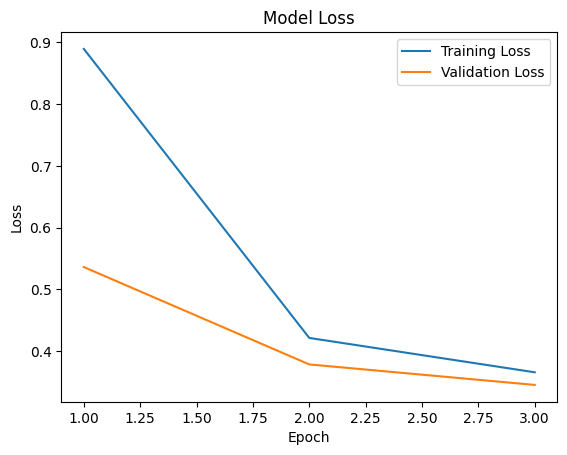

In [ ]:
plt.plot([1,2,3], qnn_history.history['loss'], label = 'Training Loss')
plt.plot([1,2,3], qnn_history.history['val_loss'], label = 'Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


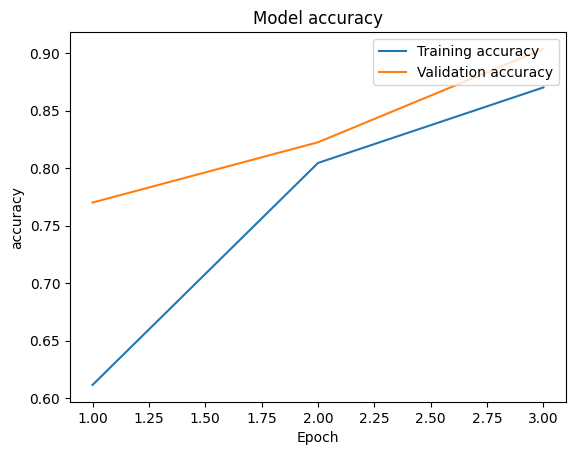

In [ ]:
plt.plot([1,2,3], qnn_history.history['hinge_accuracy'], label = 'Training accuracy')
plt.plot([1,2,3], qnn_history.history['val_hinge_accuracy'], label = 'Validation accuracy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()
